1. preprocessing dataset

In [262]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing,metrics     
import matplotlib.pyplot as plt

In [264]:
df=pd.read_csv('my-uber.csv')
df.head()
df.shape
df.describe()
df.isnull().sum()
# sns.heatmap(df.isnull(), cbar=False)
# plt.show()

Unnamed: 0             0
key                    0
fare_amount          497
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude      1
dropoff_latitude       1
passenger_count        0
dtype: int64

2. fill missing values

C:\Users\User\AppData\Local\Temp\ipykernel_11396\3001266997.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dropoff_latitude'].fillna(df['dropoff_latitude'].mean(),inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_11396\3001266997.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beha

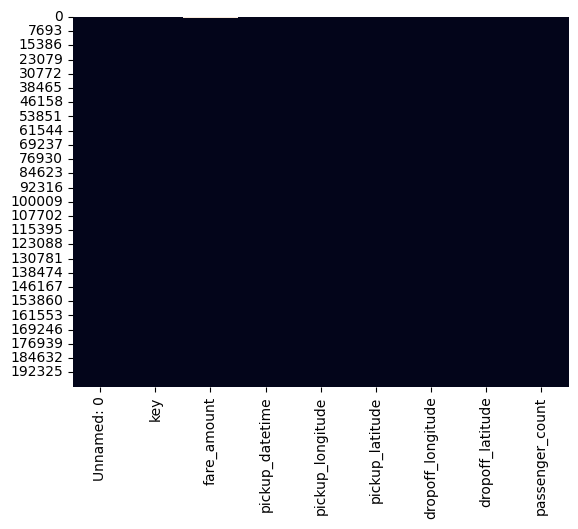

In [271]:
df['dropoff_latitude'].fillna(df['dropoff_latitude'].mean(),inplace=True)
df['dropoff_longitude'].fillna(df['dropoff_longitude'].mean(),inplace=True)
df.isnull().sum()

3. change date object to correct data type of hour day month year dayofweek

In [193]:
df.dtypes
df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
df.dtypes

Unnamed: 0                         int64
key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [195]:
df=df.assign(day=df.pickup_datetime.dt.day,hour=df.pickup_datetime.dt.hour,month=df.pickup_datetime.dt.month,year=df.pickup_datetime.dt.year)
df=df.drop('pickup_datetime',axis=1)
df.head
df.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
day                    int32
hour                   int32
month                  int32
year                   int32
dtype: object

4. fix outliers of dataset

Unnamed: 0              Axes(0.125,0.11;0.0596154x0.77)
fare_amount          Axes(0.196538,0.11;0.0596154x0.77)
pickup_longitude     Axes(0.268077,0.11;0.0596154x0.77)
pickup_latitude      Axes(0.339615,0.11;0.0596154x0.77)
dropoff_longitude    Axes(0.411154,0.11;0.0596154x0.77)
dropoff_latitude     Axes(0.482692,0.11;0.0596154x0.77)
passenger_count      Axes(0.554231,0.11;0.0596154x0.77)
day                  Axes(0.625769,0.11;0.0596154x0.77)
hour                 Axes(0.697308,0.11;0.0596154x0.77)
month                Axes(0.768846,0.11;0.0596154x0.77)
year                 Axes(0.840385,0.11;0.0596154x0.77)
dtype: object

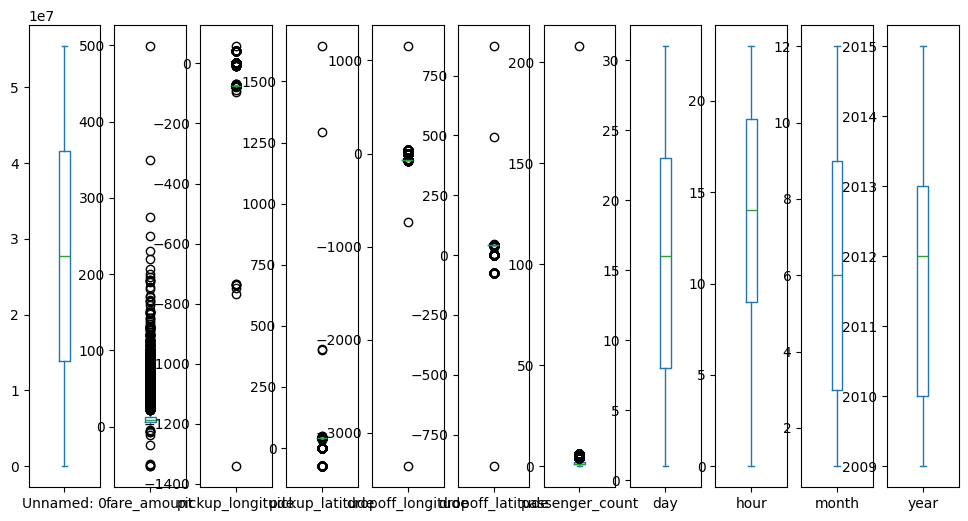

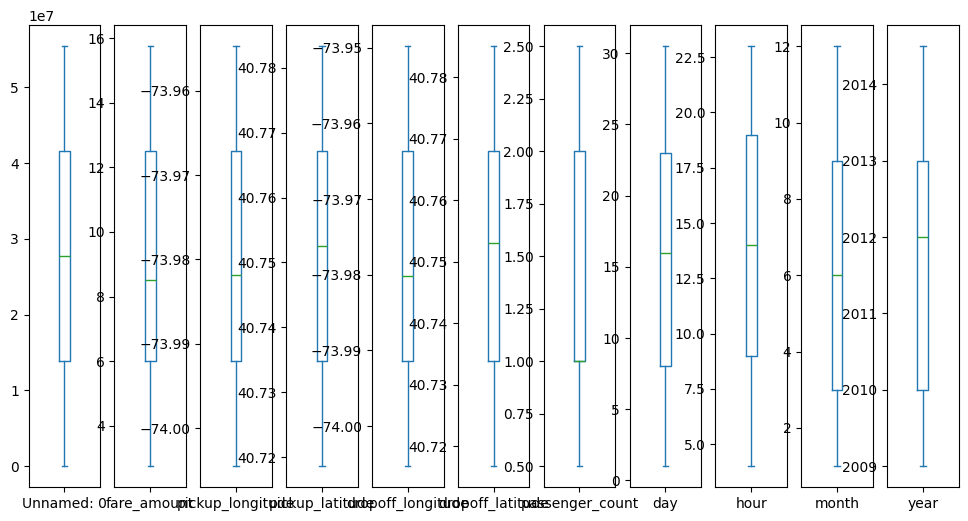

In [198]:
df.plot(kind="box",subplots=True,figsize=(12,6))
def remove_outliers(df1,col):
    Q1=df1[col].quantile(0.25)
    Q3=df1[col].quantile(0.75)
    IQR=Q1-Q3
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    df1[col]=np.clip(df1[col],lower_bound,upper_bound)
    return df1

def get_all_outliers(df,col_list):
    for c in col_list:
        df=remove_outliers(df,c)
    return df

df=get_all_outliers(df,df.select_dtypes(include=['number']).columns)
df.plot(kind="box",subplots=True,figsize=(12,6))

remove :
1. distance > 130km
2. negative latitude longitude
3. fix amount < -52

In [201]:
# Uninstall numba (fixes import error)
!pip uninstall -y numba

import haversine as hs

travel_distances = []

for pos in range(len(df)):
    pickup = (df['pickup_latitude'][pos], df['pickup_longitude'][pos])
    drop = (df['dropoff_latitude'][pos], df['dropoff_longitude'][pos])
    c = hs.haversine(pickup, drop)   # distance in km by default
    travel_distances.append(c)
df['travel_distance']=travel_distances
df.head()
df.shape

(200000, 13)

In [203]:
df=df.loc[(df.travel_distance >= 1) | (df.travel_distance<=130)]
print("remaining distances :", df.shape)
df.head()

remaining distances : (200000, 13)


,Unnamed: 0,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,month,year,travel_distance
0,24238194,2015-05-07 19:52:06.0000003,7.50,-73.999817,40.738354,-73.999512,40.723217,1.0,7.0,19,5,2014.5,1.683325
1,27835199,2009-07-17 20:04:56.0000002,7.70,-73.994355,40.728225,-73.994710,40.750325,1.0,17.0,20,7,2009.0,2.457593
2,44984355,2009-08-24 21:45:00.00000061,12.90,-74.004521,40.740770,-73.962565,40.772647,1.0,24.0,21,8,2009.0,5.005230
3,25894730,2009-06-26 08:22:21.0000001,5.30,-73.976124,40.783339,-73.965316,40.785090,2.5,26.0,8,6,2009.0,0.930569
4,17610152,2014-08-28 17:47:00.000000188,15.75,-73.954698,40.744085,-73.973082,40.761247,2.5,28.0,17,8,2014.0,2.457606


In [205]:
incorrect_coordinates = df.loc[(df.pickup_latitude > 90) | (df.pickup_latitude < -90) | (df.dropoff_latitude > 90) |(df.dropoff_latitude < -90) | (df.pickup_longitude > 180) |(df.pickup_longitude < -180)
|(df.dropoff_longitude > 90) |(df.dropoff_longitude < -180) 
] 
df.drop(incorrect_coordinates, inplace = True, errors = 'ignore') 
df.head()

,Unnamed: 0,key,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,day,hour,month,year,travel_distance
0,24238194,2015-05-07 19:52:06.0000003,7.50,-73.999817,40.738354,-73.999512,40.723217,1.0,7.0,19,5,2014.5,1.683325
1,27835199,2009-07-17 20:04:56.0000002,7.70,-73.994355,40.728225,-73.994710,40.750325,1.0,17.0,20,7,2009.0,2.457593
2,44984355,2009-08-24 21:45:00.00000061,12.90,-74.004521,40.740770,-73.962565,40.772647,1.0,24.0,21,8,2009.0,5.005230
3,25894730,2009-06-26 08:22:21.0000001,5.30,-73.976124,40.783339,-73.965316,40.785090,2.5,26.0,8,6,2009.0,0.930569
4,17610152,2014-08-28 17:47:00.000000188,15.75,-73.954698,40.744085,-73.973082,40.761247,2.5,28.0,17,8,2014.0,2.457606


In [207]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
day                  0
hour                 0
month                0
year                 0
travel_distance      0
dtype: int64

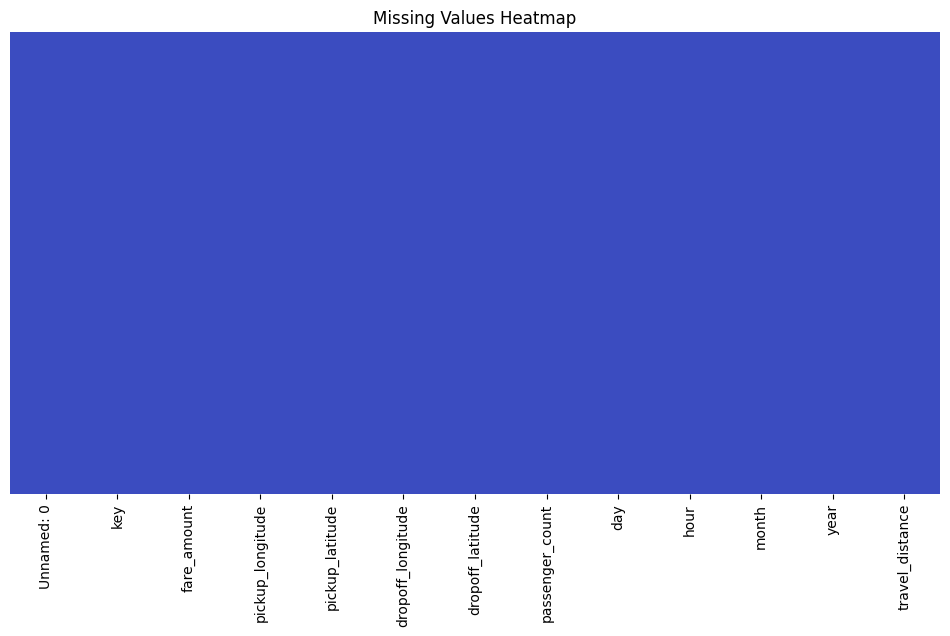

                   Unnamed: 0  fare_amount  pickup_longitude  pickup_latitude  \
Unnamed: 0           1.000000     0.000044          0.003454         0.003036   
fare_amount          0.000044     1.000000          0.051025        -0.081220   
pickup_longitude     0.003454     0.051025          1.000000         0.513447   
pickup_latitude      0.003036    -0.081220          0.513447         1.000000   
dropoff_longitude    0.006581     0.127290          0.400982         0.192063   
dropoff_latitude     0.002578    -0.105203          0.218938         0.492126   
passenger_count      0.002720     0.020370         -0.017856        -0.016739   
day                  0.000542     0.005162         -0.003740        -0.001473   
hour                -0.000307    -0.014359          0.004476         0.024974   
month                0.001299     0.031254         -0.000236         0.002078   
year                -0.001383     0.148064          0.005988        -0.011015   
travel_distance     -0.00405

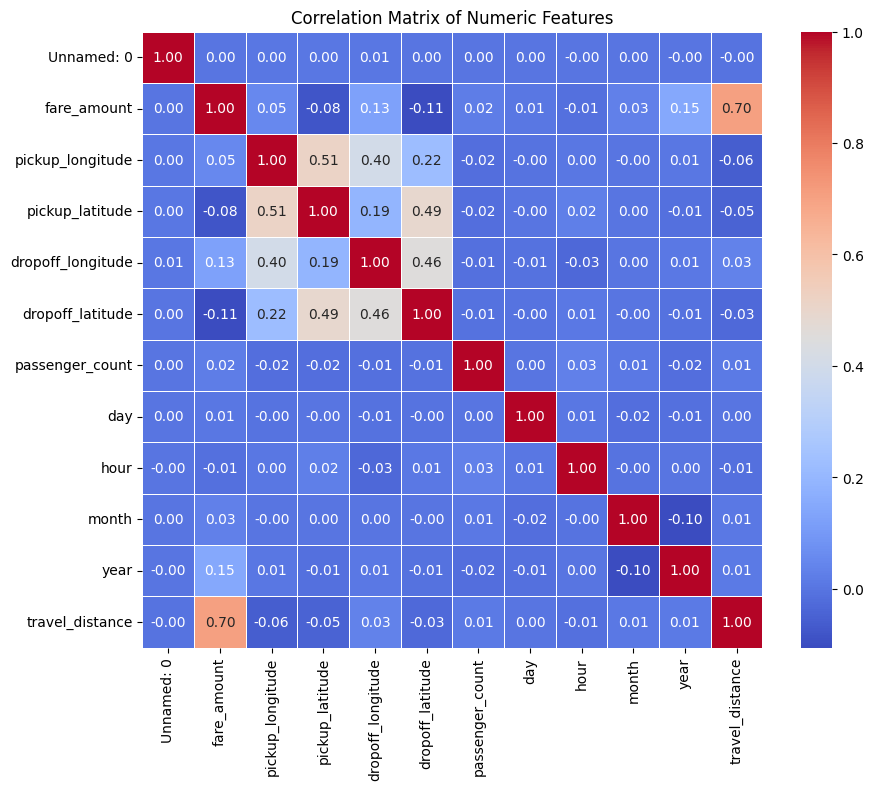

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- 1️⃣ Check missing values ---
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='coolwarm', yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

# --- 2️⃣ Compute correlation matrix (numeric columns only) ---
corr = df.corr(numeric_only=True)
print(corr)

# --- 3️⃣ Visualize correlation matrix ---
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()
